<a href="https://colab.research.google.com/github/Arun07062000/Comment-Toxicity/blob/main/Toxic_Comment_Detection(DL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data for DL and ML/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
Max_features = 200000

In [ ]:
vectorizer = TextVectorization(max_tokens=Max_features,
                               output_sequence_length=1800,
                               output_mode = 'int')

In [ ]:
vectorizer.adapt(x.values)

In [ ]:
vectorized_text = vectorizer(x.values)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data for DL and ML/jigsaw-toxic-comment-classification-challenge/test_labels.csv/test_labels.csv')

In [ ]:
train = dataset.take(int(len(dataset)*.7))
test = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
val = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Bidirectional , Dense , Embedding

In [ ]:
model = Sequential()
model.add(Embedding(Max_features+1 , 32))
model.add(Bidirectional(LSTM(32,activation = 'tanh')))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))

model.add(Dense(6,activation = 'sigmoid'))

In [ ]:
model.compile(loss = 'BinaryCrossentropy' , optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [ ]:
toxic_model = model.fit(train , epochs = 15 , validation_data=val,initial_epoch = 3)

Epoch 4/15
6981/6981 [==============================] - 832s 119ms/step - loss: 0.0364 - val_loss: 0.0349
Epoch 5/15
6981/6981 [==============================] - 720s 103ms/step - loss: 0.0331 - val_loss: 0.0287
Epoch 6/15
1735/6981 [======>.......................] - ETA: 8:23 - loss: 0.0280

<Figure size 800x500 with 0 Axes>

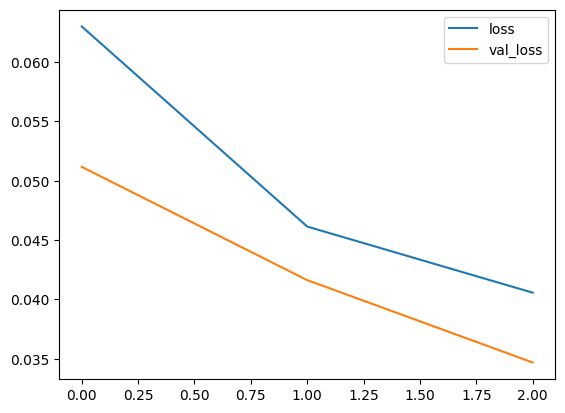

In [ ]:
plt.figure(figsize = (8,5))
pd.DataFrame(toxic_model.history).plot()
plt.show()

In [ ]:
model.save('toxic_commentClassify.h5')

In [ ]:
## Lets do some prediction
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [ ]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 54ms/step


In [ ]:
res

array([[0.99836546, 0.25451165, 0.9830631 , 0.0120605 , 0.91059816,
        0.09647837]], dtype=float32)

In [ ]:
batch_x , batch_y = test.as_numpy_iterator().next()

In [ ]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [ ]:
(model.predict(batch_x)>0.5).astype(int)

1/1 [==============================] - 0s 65ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
from tensorflow.keras.metrics import Recall , Precision , CategoricalAccuracy

In [ ]:
re = Recall()
pr = Precision()
ca = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  x_true , y_true = batch
  y_hat = model.predict(x_true)

  y_true = y_true.flatten()
  y_hat = y_hat.flatten()

  re.update_state(y_true,y_hat)
  pr.update_state(y_true,y_hat)
  ca.update_state(y_true,y_hat)

1/1 [==============================] - 0s 58ms/step


In [ ]:
print(f'Precision: {pr.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{ca.result().numpy()}')

Precision: 0.8202539682388306, Recall:0.7840327620506287, Accuracy:0.4899699091911316


In [ ]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
  

In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model = tf.keras.models.load_model('toxic_commentClassify.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you!')

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 2s 2s/step


In [ ]:
(res>0.5).astype(int)

array([[1, 0, 0, 0, 0, 0]])

In [ ]:
def result_comment(comment):
  vectorized_comment = vectorizer([comment])
  predict = model.predict(vectorized_comment)

  text = ''
  for idx,col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col,predict[0][idx]>0.5)
  return text

In [ ]:
interface = gr.Interface(fn = result_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `numeric` parameter is deprecated, and it has no effect
  super().__init__(


In [ ]:
interface.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://62313db15fa34fd212.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
